In [ ]:
# from utils import *
# patients = data_preprocessing('AE_Visit_example30k.csv', with_id=True, first_time_preprocess=False)
# patients_july = patients[patients['FirstTimetoED'].dt.month == 7]
# patients_july.to_csv('patients_with_id_July.csv', index=False)

In [7]:
import pandas as pd
from lstm_model import LSTM
import joblib
import numpy as np
import torch
import datetime
from my_model import MyModel

time = pd.to_datetime('2019-07-01 00:00:00')
data = pd.read_csv('AE_Visit_example30k.csv', low_memory=False)
patients = pd.read_csv('patients_with_id_July.csv', low_memory=False)
data = data[data['SpellID_Anon'].isin(patients['SpellID_Anon'])]
data['StartTime'] = pd.to_datetime(
        data['StartTime'], format='%d/%m/%Y %H:%M')
data['EndTime'] = pd.to_datetime(data['EndTime'], format='%d/%m/%Y %H:%M')
params = {'hidden_size': 64, 'lr': 0.001, 'region_embedding_dim': 16,
          'time_embedding_dim': 32, 'batch_size': 20000}
extractor = LSTM(vocab_size=20, region_embedding_dim=params['region_embedding_dim'],
            time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=3).to('cuda')
extractor.load_state_dict(torch.load('models/lstm_xgb/lstm.pth'))
classifier = joblib.load('models/lstm_xgb/xgb.dta')
my_model = MyModel(extractor, params, classifier, n_class=3)

In [8]:
day = 10
predict_freq = 3.5
now_times = [time + datetime.timedelta(hours=n) for n in np.arange(0, 24 * day, predict_freq)]

In [9]:
def get_patient_data(patients, time, id, my_model):
    patient = patients[patients['SpellID_Anon'] == id]
    patient.loc[:, 'FirstTimetoED'] = pd.to_datetime(
        patient['FirstTimetoED'], format='%Y-%m-%d %H:%M:%S')
    first_time = patient['FirstTimetoED'].values[0]
    time_min_d = (time-first_time).total_seconds() / 60
    patient.loc[:, 'FirstTimetoED'] = first_time.hour + first_time.minute/60
    patient = patient.values[0, 1:-1]
    time_sum = 0
    for i in range(3, len(patient), 2):
        time_sum += patient[i]
        if time_sum >= time_min_d:
            patient[i] -= (time_sum - time_min_d)
            patient[i+1:] = 0
            break
    patient = np.array(patient, dtype=np.float32).reshape(1, -1)
    y = np.array([0], dtype=np.int64)
    predict_proba, _ = my_model.evaluate(extractor, patient, y, classifier)
    temp = {
        'id': id,
        'predict_proba': predict_proba[:, 1][0],
    }
    return temp

def get_data(now_times):
    now_patients = data[(data['StartTime'] <= now_times) & (data['EndTime'] >= now_times)]
    ids = now_patients['SpellID_Anon'].values
    temp_list = [get_patient_data(patients, now_times, id, my_model) for id in ids]
    pred_beds = sum(temp['predict_proba'] for temp in temp_list)
    end_time = now_times + datetime.timedelta(hours=predict_freq)
    future_patients = data[(data['EndTime'] <= end_time) & (data['EndTime'] >= now_times)]
    transfer_status_list = pd.Series(future_patients['TransferStatus'].unique())
    uch_list = transfer_status_list[~transfer_status_list.isin(
        ['Arrival-Discharge', 'Arrival', 'Discharged', 'Transfer'])]
    future_patients_admitted_list = future_patients[future_patients['TransferStatus'].isin(uch_list)]
    act_beds = len(future_patients_admitted_list)
    return pred_beds, act_beds
pred_beds_list, act_beds_list = zip(*[get_data(now_time) for now_time in now_times])

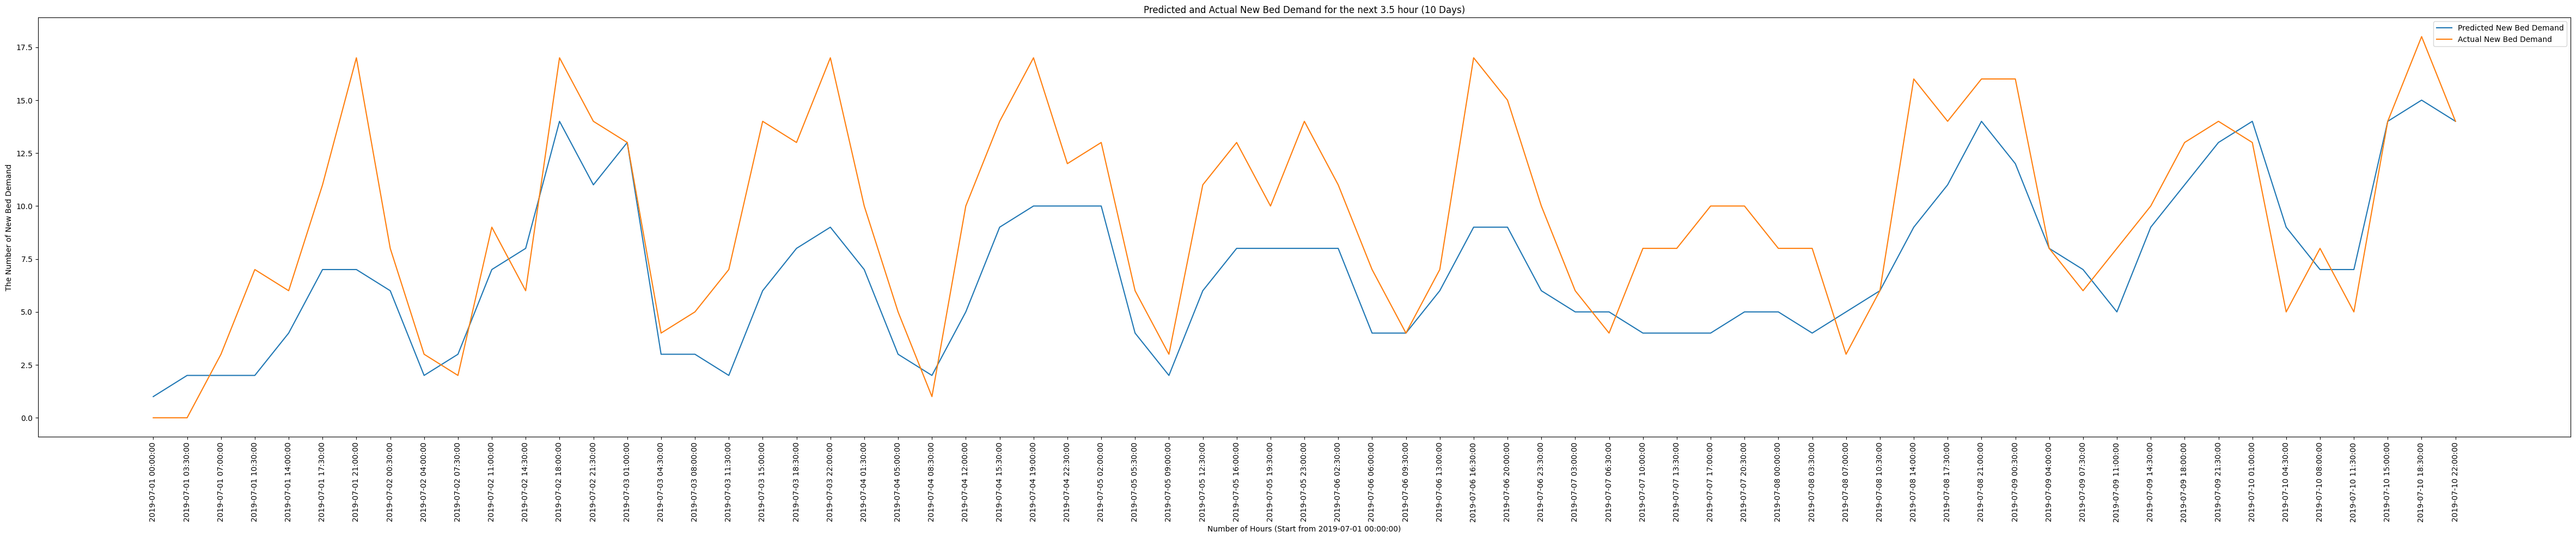

In [10]:
import matplotlib.pyplot as plt
pred_beds_list = np.ceil(pred_beds_list)
plt.figure(figsize=(60, 10))
plt.plot(pred_beds_list, label='Predicted New Bed Demand')
plt.plot(act_beds_list, label='Actual New Bed Demand')
# 将横坐标设置成相应的时间
ticks = range(0, len(pred_beds_list))
labels = [time + datetime.timedelta(hours=n) for n in np.arange(0, 24 * day, predict_freq)]

plt.xticks(ticks, labels, rotation=90)
plt.xlabel(f'Number of Hours (Start from {time})')
plt.ylabel('The Number of New Bed Demand')
plt.title(f'Predicted and Actual New Bed Demand for the next {predict_freq} hour ({day} Days)')
plt.legend()
plt.show()

In [11]:
import numpy as np
from scipy.stats import spearmanr, linregress

# act_beds_list, pred_beds_list 是你的数据
corr, _ = spearmanr(act_beds_list, pred_beds_list)

print(f"Spearman Rank Correlation Coefficient: {corr}")

Spearman Rank Correlation Coefficient: 0.8121270139659219


In [13]:
# Pearson Correlation Coefficient
correlation_matrix = np.corrcoef(act_beds_list, pred_beds_list)

# Pearson Correlation Coefficient 是矩阵的非对角线元素
pearson_correlation_coefficient = correlation_matrix[0, 1]

print(f"Pearson Correlation Coefficient: {pearson_correlation_coefficient}")

Pearson Correlation Coefficient: 0.8018448891587223


In [14]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(act_beds_list, pred_beds_list)
mae

3.0

In [15]:
from scipy import spatial
cos_sim = 1 - spatial.distance.cosine(act_beds_list, pred_beds_list)
cos_sim

0.9596659868730144